In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import torch
import re

In [2]:
def get_distribution(load_path):
    softmax = torch.nn.Softmax(dim=0)
    checkpoint = torch.load(load_path)
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    
    mean_scale_list = []
    var_scale_list = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        
        scaling_factor = re.search(pattern_scaling_factor, key)
        
        if bn_3:
            values = weights[key]
            mean_scale_list[-1][1] = torch.mean(values).cpu()
            var_scale_list[-1][1] = torch.var(values).cpu()
        if bn_7:
            values = weights[key]
            mean_scale_list[-1][2] = torch.mean(values).cpu()
            var_scale_list[-1][2] = torch.var(values).cpu()

        if scaling_factor:
            value = weights[key]
            value = softmax(value)
            mean_scale_list.append([value[0].cpu(),0,0])
            var_scale_list.append([value[0].cpu(),0,0])
    return mean_scale_list, var_scale_list

In [3]:
def plot_distribution(load_path, save_path):
    mean_scale_list, var_scale_list = get_distribution(load_path)
    x = [elem[0] for elem in mean_scale_list]
    y1 = [elem[1] for elem in mean_scale_list]
    y2 = [elem[2] for elem in mean_scale_list]
    y3 = [elem[1] for elem in var_scale_list]
    y4 = [elem[2] for elem in var_scale_list]
    
    #print(x)
    #print(y1)
    #print(y2)
    coeff1 = np.corrcoef(x, y1)
    coeff2 = np.corrcoef(x, y2)
    #coeff3 = np.corrcoef(y1, y2)
    
    print("Korrelationskoeffizient scaling factor - Durschnitt bn layer 1: " + str(coeff1[0][1]))
    print("Korrelationskoeffizient scaling factor - Durschnitt bn layer 2: " + str(coeff2[0][1]))
    #print(coeff3)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel('block scaling factor')
    ax.set_ylabel('mean channel scaling factor')
    ax.scatter(x,y1)
    ax.scatter(x,y2, marker="x")
    #ax.scatter(x,y3, marker="<")
    #ax.scatter(x,y4, marker=">")
    ax.legend(["Conv Layer 1 mean", "Conv Layer 2 mean", "Conv Layer 1 var", "Conv Layer 2 var"])
    

In [4]:
def plot_distribution_layer_wise(load_path, save_path):
    mean_scale_list, var_scale_list = get_distribution(load_path)
    x = [range(0, len(mean_scale_list))]
    y0 = [elem[0] for elem in mean_scale_list]
    y1 = [elem[1] for elem in mean_scale_list]
    y2 = [elem[2] for elem in mean_scale_list]
    y3 = [elem[1] for elem in var_scale_list]
    y4 = [elem[2] for elem in var_scale_list]
    
    coeff0 = np.corrcoef(x, y0)
    coeff1 = np.corrcoef(x, y1)
    coeff2 = np.corrcoef(x, y2)
    #coeff3 = np.corrcoef(y1, y2)
    
    print("Korrelationskoeffizient layer - block scaling factor: " + str(coeff0[0][1]))
    print("Korrelationskoeffizient layer - Durschnitt bn layer 1: " + str(coeff1[0][1]))
    print("Korrelationskoeffizient layer - Durschnitt bn layer 2: " + str(coeff2[0][1]))
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel('Layer')
    ax.set_ylabel('Factor')
    ax.scatter(x, y0)
    ax.scatter(x,y1)
    ax.scatter(x,y2, marker="x")
    ax.legend(["Block Scaling Factor", "Conv Layer 1 mean", "Conv Layer 2 mean", "Conv Layer 1 var", "Conv Layer 2 var"])
    

Korrelationskoeffizient scaling factor - Durschnitt bn layer 1: 0.6144600960000758
Korrelationskoeffizient scaling factor - Durschnitt bn layer 2: 0.5325721130735753


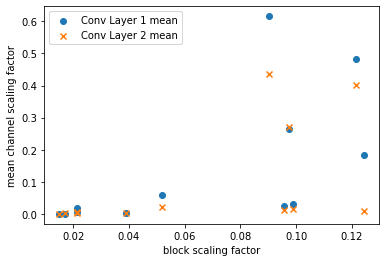

In [5]:
plot_distribution("models/birdnet_v1/birdnet_final.pt", "LOL")

Korrelationskoeffizient scaling factor - Durschnitt bn layer 1: 0.4443100706071978
Korrelationskoeffizient scaling factor - Durschnitt bn layer 2: 0.347990008303495


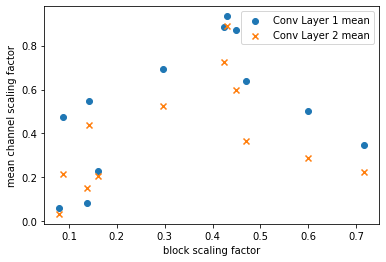

In [6]:
plot_distribution("models/birdnet/birdnet_final.pt", "LOL")

Korrelationskoeffizient layer - block scaling factor: -0.2831722304013819
Korrelationskoeffizient layer - Durschnitt bn layer 1: -0.7806601845686698
Korrelationskoeffizient layer - Durschnitt bn layer 2: -0.7562429082439706


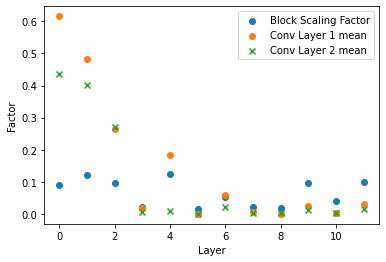

In [7]:
plot_distribution_layer_wise("models/birdnet_v1/birdnet_final.pt", "LOL")

Korrelationskoeffizient layer - block scaling factor: 0.01668654287170392
Korrelationskoeffizient layer - Durschnitt bn layer 1: -0.8184502873389721
Korrelationskoeffizient layer - Durschnitt bn layer 2: -0.8050366718901714


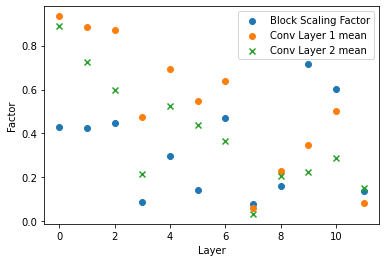

In [8]:
plot_distribution_layer_wise("models/birdnet/birdnet_final.pt", "LOL")

In [9]:
def plot_graphs(load_path, save_name):
    checkpoint = torch.load(load_path)
    test_acc = np.array(checkpoint['test_acc_list'])
    train_acc = np.array(checkpoint['train_acc_list'])
    test_loss = np.array(checkpoint['test_loss_list'])
    train_loss = np.array(checkpoint['train_loss_list'])
    x = np.array(list(range(0, len(test_acc))))


    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    if len(train_acc) == len(x):
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x, train_acc, color='r')
    else:
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x[1:], train_acc, color='r')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('loss')  # we already handled the x-label with ax1
    if len(train_loss) == len(x):
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, train_loss, color='y')
    else:
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x[1:], train_loss, color='y')
    ax2.tick_params(axis='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    ax2.legend(['test loss', 'train loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    plt.savefig(save_name)
    #plt.show()


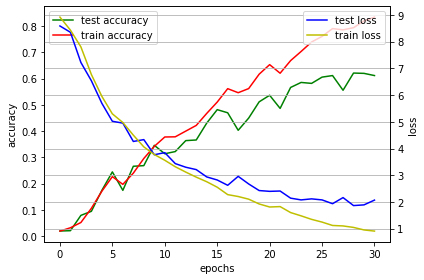

In [10]:
plot_graphs("models/birdnet_v1/birdnet_final.pt", "full")

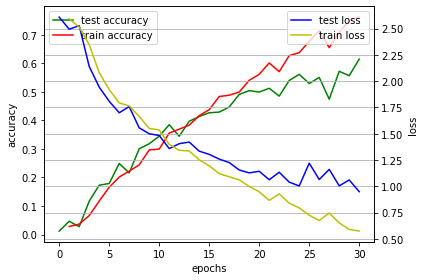

In [11]:
plot_graphs("models/birdnet/birdnet_final.pt", "full")

Korrelationskoeffizient layer - block scaling factor: -0.38147614914282546
Korrelationskoeffizient layer - Durschnitt bn layer 1: -0.5809846402547967
Korrelationskoeffizient layer - Durschnitt bn layer 2: -0.6539453778366804


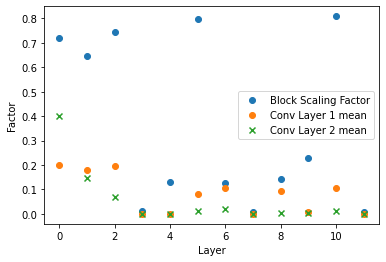

In [15]:
plot_distribution_layer_wise("models/birdclef_pruned/birdnet_v1.pt", "full")

Korrelationskoeffizient scaling factor - Durschnitt bn layer 1: 0.7698292114000561
Korrelationskoeffizient scaling factor - Durschnitt bn layer 2: 0.49079089086014094


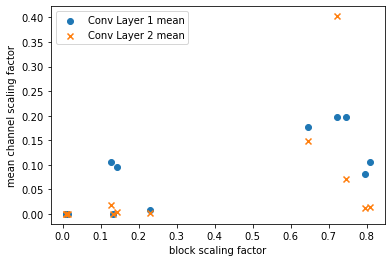

In [16]:
plot_distribution("models/birdclef_pruned/birdnet_v1.pt", "full")